# Purpose of Notebook

## Model Descriptions
We suppose that $X(t,T): \mathbb{R}^2_+ \mapsto [0,1]$ is the _recrystillization fraction_, and is a function of $t$ the time and $T$ the _isothermal_ and _steady_ temperature, (_i.e._ the temperature is uniform in space and independent of time).

### JMAK

The parameters of interest are the incubation time $t_{inc}$, the exponent, $n$, and the rate coefficient $b$. $A_1,A_2,A_1,A_2$ are parameters involved in the Arrhenius process description of the temperature dependence of $b$ and $t_{inc}$ on $T$. 

$
X = 1 - \exp{\left( -b^n (t - t_{inc})^n \right)} + \epsilon \\ 
b = A_1 \exp{\left(B_1/T \right)} \\ 
t_{inc} = A_2 \exp{\left(B_2/T \right)} \\ 
$

### Generalized Logistic 

We suppose that the recrystillization fractionmay be modeled using a (generalized) logistic (GL) growth function. The temperature dependence follows through the Arrhenius process modeled for the growth rate $B$ and starting time $M$.

$
X = \frac{1}{(1 + e^{-B (t - M)})^{1/\nu}} \\ 
B = A_1 \exp{\left(B_1/T \right)} \\ 
M = A_2 \exp{\left(B_2/T \right)} \\ 
$

Note that because the parameters tend to be on very different scales, we employ a log re-parameterization. That is, for example, 

$\ln{B} = \ln{A_1} + \frac{B_1}{T} = a_1 + \frac{B_1}{T} \implies B = \exp{\left( a_1 + \frac{B_1}{T}\right)}$

where $a_1 = \ln{A_1}$

## Model Assessment
###  Model Fit
    2. Weighted Non-Linear Least Squares
    3. Robust Regression

### Assessing application: Extrapolation to lower temperatures

In [1]:
import numpy as np
from scipy.optimize import differential_evolution, curve_fit
from typing import Callable
from dataclasses import dataclass
import math
import warnings
from matplotlib import pyplot as plt
from matplotlib import rc
from common_util import LogLinearArrheniusModelFunc,jmak_function,generalized_logistic
from scipy.stats.qmc import LatinHypercube

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
warnings.filterwarnings('ignore',category = RuntimeWarning)
warnings.filterwarnings('ignore',category = SyntaxWarning)


def global_optimize_ls(f: Callable,
                       xdata: np.ndarray,
                       ydata: np.ndarray,
                       bounds: np.ndarray,
                       sigma: np.ndarray = None,
                       p0: np.ndarray = None,
                       *args,**kwargs):
    
    """
    handy to check if the local optimization is working okay.
    """
    w = np.ones_like(ydata) if not isinstance(sigma,np.ndarray) and sigma is None else 1/sigma**2
    w/=np.linalg.norm(w)

    def resid(theta: np.ndarray):
        return np.sum((w*(ydata - f(xdata,*theta))**2))
    
    return differential_evolution(resid,bounds,*args,polish = True,**kwargs)

def local_optimize_ls(fun: Callable,
                      xdata: np.ndarray,
                      ydata: np.ndarray,
                      bounds: np.ndarray,
                      *args,
                      p0: np.ndarray = None,
                      **kwargs):
    """ 
    small wrapper to interface with fit method in the model function
    """
    xopt,pcov, info_dict,msg, ier = \
          curve_fit(fun,xdata,ydata,*args,p0 = p0,bounds = bounds.T,**kwargs,full_output = True)
    
    return xopt,True,msg

def model_std_dev(fun: Callable,
                  xdata: np.ndarray,
                  ydata: np.ndarray,
                  xopt: np.ndarray, 
                  sigma: np.ndarray = None):
    
    yhat = fun(xdata,*xopt)
    if not isinstance(sigma,np.ndarray) and sigma is None:
        sigma = np.ones_like(ydata)
    
    resid = ydata - yhat
    return np.sum(resid**2/sigma**2)**0.5

def restarted_local_optimize_ls(fun: Callable,
                                xdata: np.ndarray,
                                ydata: np.ndarray,
                                bounds: np.ndarray,
                                *args,
                                opt_metric: Callable = model_std_dev,
                                n_restarts: int = 100,
                                p0: np.ndarray = None,
                                sigma = None,
                                **kwargs):
    
    """
    can't converge to a solution consistnely without a good initial guess.
    """
    params = LatinHypercube(bounds.shape[0]).random(n_restarts - 1)
    params = params*(bounds[:,1] - bounds[:,0]) + bounds[:,0]
    params = np.vstack([params,bounds.mean(axis = 1)])
    metric = np.ones(n_restarts)*float('inf')
    for i in range(params.shape[0]):
        try:
            xopt,_,_ = \
                local_optimize_ls(fun,xdata,ydata,*args,p0 = params[i,:],bounds = bounds,sigma = sigma,
                                **kwargs)
            
            params[i] = xopt
            metric[i] = opt_metric(fun,xdata,ydata,xopt,sigma = sigma)
        except RuntimeError as rte:
            warnings.warn(f'Optimization failed: {str(rte)}')
            pass

    xopt = params[np.argmin(metric)]    
    return xopt,True,True


In [4]:
import pandas as pd
import pickle
from common_util import setup_axis_default

file_to_label  = {'rf_data/alfonso_data/highly_rolled.csv': 'Lopez et al. (2015) - HR',
                'rf_data/alfonso_data/moderate_roll.csv': 'Lopez et al. (2015) - MR',
                'rf_data/richou_data/batch_a_data.csv': 'Richou et al. (2020) - Batch A',
                'rf_data/richou_data/batch_b_data.csv': 'Richou et al. (2020) - Batch B',
                'rf_data/yu_data/data.csv': 'Yu et al. (2017)'}

def get_loglinear_arrhenius_parameter_bounds_from_file(plabel: str,
                                             file: str,
                                             alpha = 1e-3):
    
    """
    read log-linear arrhenius model from file (approx. estimated in seperate notebook),
    and provide nonlinear optimization bounds for the parameters
    """
    
    label = file_to_label[file]
    with open(f'.model/{plabel}_{label}_first_{2}.pkl','rb') as f:
        ols_res_f = pickle.load(f).parameter_confidence_interval(alpha)
    
    with open(f'.model/{plabel}_{label}_last_{2}.pkl','rb') as f:
        ols_res_l = pickle.load(f).parameter_confidence_interval(alpha)
    
    ci = np.concatenate([ols_res_f,
                         ols_res_l],axis = 1)
    
    bounds = np.array([np.min(ci,axis = 1),np.max(ci,axis = 1)]).T
    return bounds,bounds.mean(axis = 1)
    
def read_prepare_data(file: str,
                      mult = 1.,
                      exclude_index = []) -> pd.DataFrame:
    
    """
    helper function to read data from file and make sure that the values
    are within the bounds of the model. Also make sure that standard 
    deviations are above some minimum value that I couldn't estimate
    from the plots.
    """
    df = pd.read_csv(file,index_col = 0)
    index = np.ones(df.shape[0],dtype = bool)   
    index[exclude_index] = False
    df = df.loc[index,:]
    
    df['time']*=mult
    t = df['time'].to_numpy()
    T = df['temperature'].to_numpy() + 273.15
    X = df['X'].to_numpy()
    X[X <= 0 ] = 0.0
    X[X >= 1] = 1
    with warnings.catch_warnings(action = 'ignore'):
        try:
            df.loc[df['std'] == 0,'std'] = max(np.min(df.loc[df['std'] > 0,'std']),0.1e-3)
        except KeyError as ke:
            df['std'] = 1e-3
            print(f'No standard deviation column found, using {1e-3} for all values')

    return t,T,X,df

def jmak_fit_model_setup(file: str,
                         bounds_n: np.ndarray = np.array([[1.0,3.0]]),
                         mult = 1.,
                         exclude_index = [],
                         **kwargs):
    
    """
    neccssary setup for fitting the JMAK model
    """
    bounds_tinc,p0_tinc = get_loglinear_arrhenius_parameter_bounds_from_file('log_tinc',file,**kwargs)
    bounds_b,p0_b = get_loglinear_arrhenius_parameter_bounds_from_file('log_b',file, **kwargs)
    bounds = np.concatenate([bounds_n,bounds_b,bounds_tinc],axis = 0)
    p0 = np.concatenate([p0_b,p0_tinc])
    return *read_prepare_data(file, mult = mult,exclude_index = exclude_index),bounds,p0

def gl_fit_model_setup(file: str,
                       bounds_nu: np.ndarray = np.array([[1e-3,1.0]]),
                       mult = 1.,
                        exclude_index = [],
                       **kwargs):

    """
    neccssary setup for fitting the GL model
    """
    bounds_B,p0_B = get_loglinear_arrhenius_parameter_bounds_from_file('log_B',file,**kwargs)
    bounds_M,p0_M = get_loglinear_arrhenius_parameter_bounds_from_file('log_tinc',file, **kwargs)
    bounds = np.concatenate([bounds_nu,bounds_B,bounds_M],axis = 0)
    p0 = np.concatenate([p0_B,p0_M])
    return *read_prepare_data(file,mult = mult,exclude_index = exclude_index),bounds,p0




### Visually Examining Regression Fits

First we'll fit both the JMAK and Generalized Logistic Models to two data sets, the "Highly Rolled" and "Moderately Rolled" data from Alfonso _et al._'s study. We'll use both the linear (squared error) and huber loss functions (for robust estimation) during the optimizations. Because experimental variance (errors) are reported, we should use weighted least squares to weight the samples according to our certainty in their values.

The below results shows that the huber loss creates difficulties in finding acceptable model parameter values during optimization with the Generalized Logistic Model; no such difficulties are evident with the JMAK model. Examining the metrics of:

1. model standard deviation (maximum likelihood estimation)
2. (scaled) maximum absolute error 
3. log - likelihood

The GLM model using WLS estimation _slightly_ outperforms the JMAK model across the board. The performance isn't convincingly better enough to choose the GLM model over the JMAK, and assessing each model on the end goal of _extrapolation_ is a better assessment.

No standard deviation column found, using 0.001 for all values


C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_53116\1688456118.py:95: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')


No standard deviation column found, using 0.001 for all values
No standard deviation column found, using 0.001 for all values


C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_53116\1688456118.py:95: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_53116\1688456118.py:51: OptimizeWarning: Covariance of the parameters could not be estimated
  curve_fit(fun,xdata,ydata,*args,p0 = p0,bounds = bounds.T,**kwargs,full_output = True)


No standard deviation column found, using 0.001 for all values
result for file: data.csv
                  model           method      n     a1         B1      a2  \
0                  JMAK         weighted  1.000  1.882 -16883.404 -17.022   
0                  JMAK  robust weighted  1.069  3.553 -19902.687 -68.136   
0  Generalized Logistic         weighted  0.443 -0.878 -11665.489 -12.175   
0  Generalized Logistic  robust weighted  0.252  3.550 -18787.847 -29.101   

          B2  std. dev.  max abs. error  log-likelihood  
0  38277.403     64.082         186.392        4868.727  
0 -52124.528     98.192         310.578        4650.222  
0  31707.271     89.511         195.633        4697.618  
0 -25677.482     97.744         235.974        4652.565  
----------------------------------------



C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_53116\1441747451.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,2].legend(fontsize = 9,ncols = 2)


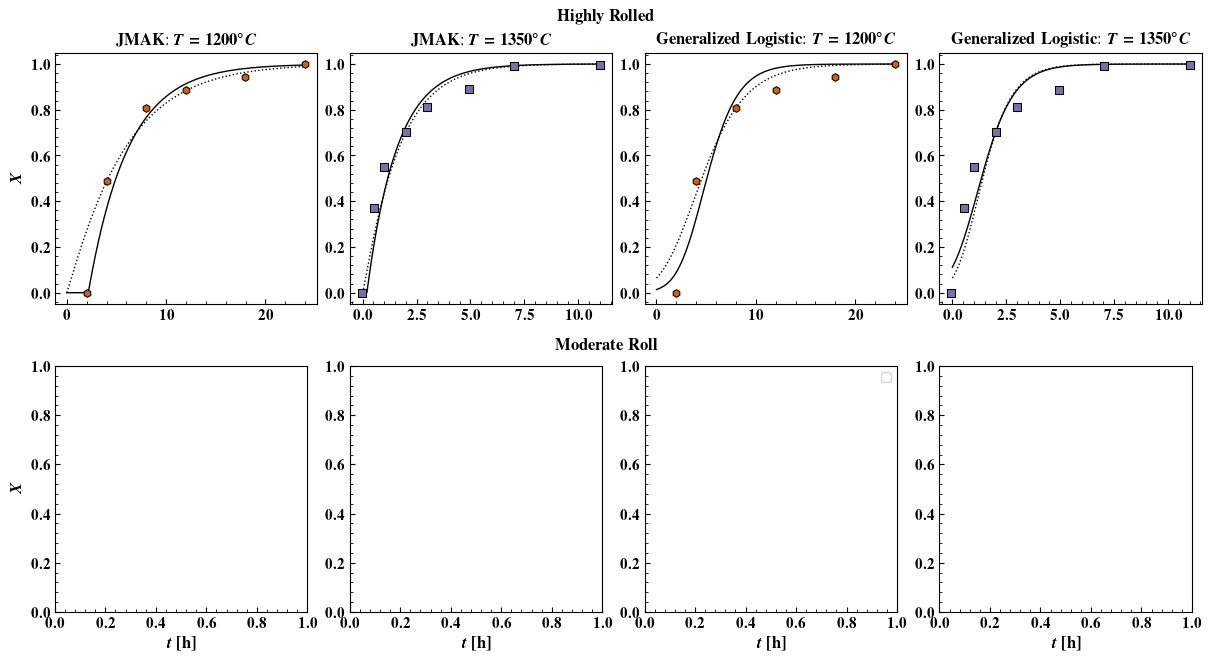

In [8]:
import copy
np.random.seed(55)
#setup fitting for models
model_fit = {'JMAK':(jmak_fit_model_setup,jmak_function),
             'Generalized Logistic':(gl_fit_model_setup,generalized_logistic)}

methods = {'weighted':'linear',
           'robust weighted':'huber'}

models = {}
styles = ['-',':']
labels = ['WLS','WRLS']

#set-up figure and axes
fig = plt.figure(constrained_layout=True,figsize= (12,6.5))
subfigs = fig.subfigures(nrows=2, ncols=1)

axes = []
for row, subfig,row_title in zip(range(2),subfigs,['Highly Rolled','Moderate Roll']):
        subfig.suptitle(r'\textbf{' + row_title +  '}',fontsize = 12)
        axs = subfig.subplots(nrows=1, ncols=4)
        axes.append(axs)

axes = np.array(axes)

colors = plt.get_cmap('Dark2')([0.2,0.3])

data_files = {'data.csv': []}

data_labels = ['yu']

columns = ['model','method','n','a1','B1','a2','B2','std. dev.','max abs. error','log-likelihood'] 

for j,file,temperatures in zip(range(2),data_files,[[1200,1350],[1500,1800]]):
        results_frames = []
        data_file = f'rf_data/yu_data/{file}'
        data = pd.read_csv(data_file,index_col = 0)
        start_index = 0

        for model_to_fit in model_fit:
                setup,fit_func = model_fit[model_to_fit]
                for method,ls,label in zip(methods,styles,labels): 
                        results = [] 
                        
                        #set-up model fitting and fit model
                        t,T,X,df,bounds,p0 = setup(data_file,mult = 3600,
                                                        exclude_index = data_files[file])        
                        
                        sigma = df['std'].to_numpy()
                        model = LogLinearArrheniusModelFunc().fit(fit_func,t,T,X,restarted_local_optimize_ls,bounds.copy(),
                                                                  sigma = sigma,loss = methods[method],p0 = p0,max_nfev = 5000)
                        
                        with open(f'.model/{model_to_fit}_{data_labels[j]}_{method}.pkl','wb') as f:
                                pickle.dump(model,f)
                        
                        #get summary statistics
                        resid = X - model.predict(np.array([t,T]).T)
                        n = resid.shape[0]
                        std_dev = np.mean(resid**2/sigma**2)**0.5
                        max_err = np.max(np.abs(resid/sigma))
                        log_like = -n*math.log(2*math.pi) - n/2*np.log(np.prod(std_dev*sigma**2)) - 0.5*np.sum(resid**2/(std_dev*sigma)**2)

                        results.append([model_to_fit,method,
                                        *np.round(model.parameters(),3),
                                        round(std_dev,3),
                                        round(max_err,3),
                                        round(log_like,3)])
                        
                        #vizualize the model performance
                        for i,T_plot in enumerate(temperatures):
                                data_df = data.loc[data['temperature'] == T_plot]
                                tplot = np.linspace(0,data_df['time'].max(),1000)*3600
                                Xnew = np.array([tplot,(T_plot + 273.15)*np.ones_like(tplot)]).T
                                axes[j,i + start_index].plot(tplot/3600,model.predict(Xnew),
                                        color = 'k',lw = 1.,label = label,ls = ls)
                        
                        results_frames.append(pd.DataFrame(results,columns = columns))  
                
                #scatter plot selected values of the fitted data
                for i,marker,color,T_plot in zip(range(2),['h','s'],colors,temperatures):
                        title = r'\textbf{' + f'{model_to_fit}' + '}' + f': $T = {T_plot} ^\circ C$'
                        data_df = data.loc[data['temperature'] == T_plot]
                        axes[j,i + start_index].set_title(title,fontsize = 12)
                        try:
                                axes[j,i + start_index].errorbar(data_df['time']/3600,data_df['X'].to_numpy(),yerr = data_df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
                        except KeyError: 
                                pass
                
                        axes[j,i + start_index].scatter(data_df['time'],data_df['X'],facecolor  = color,edgecolor = 'k',
                                lw = 0.75,s = 30,marker = marker,zorder = 1000) 
                
                start_index +=2
        

        print(f'result for file: {file}')
        print(pd.concat(results_frames))

        print('----------------------------------------\n')


#final formatting for plots
for ax in np.ravel(axes)[4:]:
        ax.set_xlabel(r'$t$ \textbf{[h]}',fontsize = 12)

for ax in np.ravel(axes):
        setup_axis_default(ax)

for i in range(2):
        axes[i,0].set_ylabel(r'$X$',fontsize = 12)

axes[1,2].legend(fontsize = 9,ncols = 2)
#fig.savefig('images/example_model_fit_alfonso.svg',bbox_inches = 'tight')


### Extrapolation

C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_16984\2428252531.py:96: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')


result for file: rf_data/alfonso_data/highly_rolled.csv
                  model           method      n      a1         B1      a2  \
0                  JMAK         weighted  1.377  19.476 -43169.938 -19.142   
0                  JMAK  robust weighted  1.602  16.949 -39706.768 -19.684   
0  Generalized Logistic         weighted  0.017  16.381 -37690.085 -37.627   
0  Generalized Logistic  robust weighted  0.082   8.806 -55327.441 -42.405   

          B2  std. dev.  max abs. error  log-likelihood  
0  43526.610      2.883           7.234         559.958  
0  44249.208      2.294           6.319         586.459  
0  67772.498      1.860           5.698         610.068  
0  38338.720     30.305          78.151         137.463  
----------------------------------------



C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_16984\2428252531.py:96: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_16984\2428252531.py:96: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')


result for file: rf_data/alfonso_data/moderate_roll.csv
                  model           method      n      a1         B1      a2  \
0                  JMAK         weighted  1.544  34.787 -71034.559 -36.522   
0                  JMAK  robust weighted  2.997  32.559 -68577.888 -43.252   
0  Generalized Logistic         weighted  0.060  36.252 -72088.420 -76.651   
0  Generalized Logistic  robust weighted  0.063  35.388 -70782.774 -73.502   

          B2  std. dev.  max abs. error  log-likelihood  
0  73057.089      6.804          15.971         239.233  
0  40212.065      3.723           8.132         284.785  
0  58901.642      7.033          15.170         236.426  
0   5850.706      5.721          13.291         253.320  
----------------------------------------

result for file: rf_data/richou_data/batch_a_data.csv
                  model           method      n      a1         B1      a2  \
0                  JMAK         weighted  2.248  24.971 -57448.199 -32.744   
0          

C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_16984\2428252531.py:96: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')


result for file: rf_data/richou_data/batch_b_data.csv
                  model           method      n      a1         B1      a2  \
0                  JMAK         weighted  1.564  15.430 -41179.112 -38.845   
0                  JMAK  robust weighted  1.465  15.015 -40386.015 -39.521   
0  Generalized Logistic         weighted  0.217  16.057 -40695.113 -32.785   
0  Generalized Logistic  robust weighted  0.141  19.853 -47782.723  36.474   

           B2  std. dev.  max abs. error  log-likelihood  
0   80673.491      1.345           2.185          94.141  
0   82088.903      1.361           2.240          93.690  
0   70277.367      1.304           2.185          95.275  
0 -162898.658      1.036           2.213         103.720  
----------------------------------------



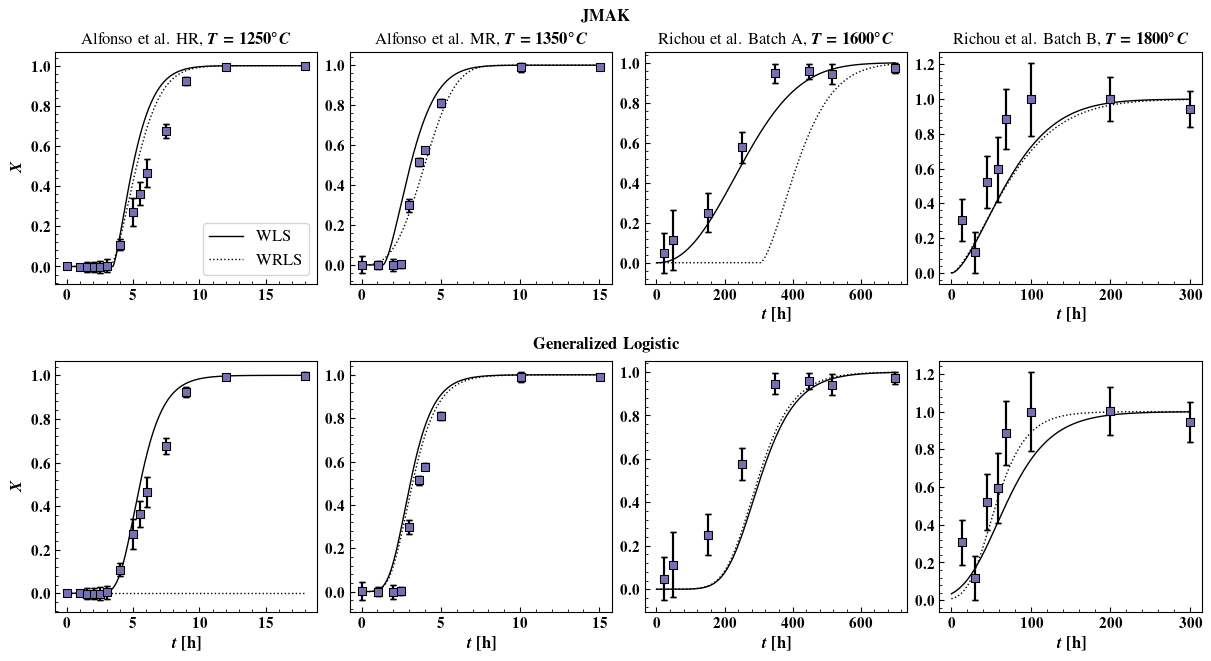

In [4]:
import copy

model_fit = {'JMAK':(jmak_fit_model_setup,jmak_function),
             'Generalized Logistic':(gl_fit_model_setup,generalized_logistic)}

methods = {'weighted':'linear',
           'robust weighted':'huber'}

models = {}
styles = ['-',':']
labels = ['WLS','WRLS']

#set-up figure and axes
fig = plt.figure(constrained_layout=True,figsize= (12,6.5))
subfigs = fig.subfigures(nrows=2, ncols=1)

axes = []
for row, subfig,row_title in zip(range(2),subfigs,['JMAK','Generalized Logistic']):
        subfig.suptitle(r'\textbf{' + row_title +  '}',fontsize = 12)
        axs = subfig.subplots(nrows=1, ncols=4)
        axes.append(axs)

axes = np.array(axes)

data_files = ['rf_data/alfonso_data/highly_rolled.csv',
              'rf_data/alfonso_data/moderate_roll.csv',
              'rf_data/richou_data/batch_a_data.csv',
              'rf_data/richou_data/batch_b_data.csv']

titles = ['Alfonso et al. HR','Alfonso et al. MR','Richou et al. Batch A','Richou et al. Batch B']
T_extrap = [1250,1350,1600,1800]
multipliers = [3600.,3600.,1.,1.]
columns = ['model','method','n','a1','B1','a2','B2','std. dev.','max abs. error','log-likelihood'] 

for j in range(axes.shape[1]):
        axes[0,j].set_title(titles[j] + f', $T = {T_extrap[j]} ^\circ C$',fontsize = 12)

for j,data_file,T_extrap in zip(range(4),data_files,T_extrap):
        results_frames = []
        data = pd.read_csv(data_file,index_col = 0)

        for i,model_to_fit in enumerate(model_fit):
                setup,fit_func = model_fit[model_to_fit]
                for method,ls,label in zip(methods,styles,labels): 
                        results = [] 
                        #set-up model fitting and fit model
                        t,T,X,df,bounds,p0 = setup(data_file,mult = multipliers[j])        
                        
                        train_idx = T != T_extrap + 273.15
                        test_idx = T == T_extrap + 273.15
                        
                        sigma = df['std'].to_numpy()
                        model = LogLinearArrheniusModelFunc().fit(fit_func,t[train_idx],T[train_idx],X[train_idx],restarted_local_optimize_ls,bounds.copy(),
                                                                  sigma = sigma[train_idx],loss = methods[method],p0 = p0,max_nfev = 5000)
                        
                        
                        #get summary statistics
                        resid = X[test_idx] - model.predict(np.array([t[test_idx],T[test_idx]]).T)
                        n = resid.shape[0]
                        std_dev = np.mean(resid**2/sigma[test_idx]**2)**0.5
                        max_err = np.max(np.abs(resid/sigma[test_idx]))
                        log_like = -n*math.log(2*math.pi) - n/2*np.log(np.prod(std_dev*sigma[test_idx]**2)) - 0.5*np.sum(resid**2/(std_dev*sigma[test_idx]**2))

                        results.append([model_to_fit,method,
                                        *np.round(model.parameters(),3),
                                        round(std_dev,3),
                                        round(max_err,3),
                                        round(log_like,3)])
                        
                        results_frames.append(pd.DataFrame(results,columns = columns))  
                
                        data_df = data.loc[data['temperature'] == T_extrap]
                        tplot = np.linspace(0,data_df['time'].max()*multipliers[j],1000)
                        Xnew = np.array([tplot,(T_extrap + 273.15)*np.ones_like(tplot)]).T
                        axes[i,j].plot(tplot/multipliers[j],model.predict(Xnew),
                                color = 'k',lw = 1.,label = label,ls = ls)
                        
                        axes[i,j].errorbar(data_df['time'],data_df['X'].to_numpy(),yerr = data_df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
                        axes[i,j].scatter(data_df['time'],data_df['X'],facecolor  = color,edgecolor = 'k',
                                lw = 0.75,s = 30,marker = marker,zorder = 1000) 
                

        print(f'result for file: {data_file}')
        print(pd.concat(results_frames))

        print('----------------------------------------\n')


for ax in np.ravel(axes)[2:]:
        ax.set_xlabel(r'$t$ \textbf{[h]}',fontsize = 12)

for ax in np.ravel(axes):
        setup_axis_default(ax)

for i in range(2):
        axes[i,0].set_ylabel(r'$X$',fontsize = 12)

axes[0,0].legend(fontsize = 12)
fig.savefig('images/model_extrapolation_higher_temperature.svg',bbox_inches = 'tight')